## Vehicle Detection

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

---

In [1]:
import os
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.feature import hog
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label

%matplotlib qt

/Users/yujin/anaconda/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Frame extraction from video

In [6]:
dirname = 'video_image'
if not os.path.exists(dirname):
    os.makedirs(dirname)

vidcap = cv2.VideoCapture('test_video.mp4')
images =[]
ret = True
i = 0
while(ret):
    ret, frame = vidcap.read()
    
    if(ret == False):
        break
    filename = 'frame' +str(i).zfill(4) +'.png'
    cv2.imwrite(os.path.join(dirname, filename), frame)
    i += 1
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
        
vidcap.release()

In [11]:
# save the test image name as list type

imagedir_lists = glob.glob('video_image/*.png')
imagedir_lists = (sorted(image_lists))

items = os.listdir("video_image/")
items = (sorted(items))
imagename_list = []
for names in items:
    if names.endswith(".png"):
        imagename_list.append(names)

## Training Data Load

In [12]:

folder_vehicles = glob.glob('vehicles/*')
folder_nonvehicles = glob.glob('non-vehicles/*')

cars = []
notcars = []

# Read in our vehicles and non-vehicles
for i in range(len(folder_vehicles)):
    image_names = glob.glob(folder_vehicles[i] + '/*.png')    
    for fname in image_names:
        cars.append(fname)
        
for i in range(len(folder_nonvehicles)):
    image_names = glob.glob(folder_nonvehicles[i] + '/*.png')    
    for fname in image_names:
        notcars.append(fname)    


___

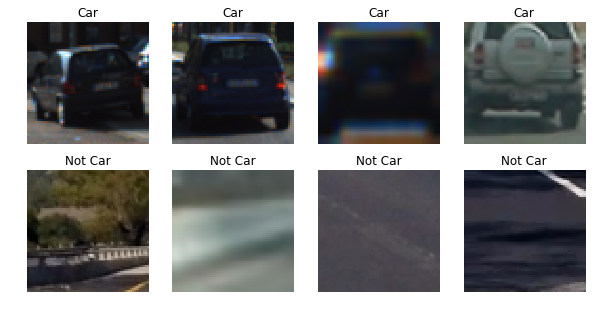

In [31]:
%matplotlib inline
### make example image
fig = plt.figure(figsize = (10,5))
# Call our function with vis=True to see an image output
for i in range(0, 4):
    
    ind = np.random.randint(0, len(cars))
    # Read in the car image
    car_example = mpimg.imread(cars[ind])

    # Generate a random index to look at a notcar image
    ind = np.random.randint(0, len(notcars))
    # Read in the notcar image
    notcar_example = mpimg.imread(notcars[ind])
    
    plt.subplot(2,4,1+i)
    plt.imshow(car_example, cmap = 'gray')
    plt.title('Car')
    plt.axis('off')
    plt.subplot(2,4,5+i)
    plt.imshow(notcar_example, cmap = 'gray')
    plt.title('Not Car')
    plt.axis('off')
    
    
plt.savefig("examples/car_not_car.png")

## Histogram of Oriented Gradients (HOG) feature extraction

In [13]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features


In [14]:
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    #list_features =[]
    #list_spatial_features = []    
    #list_hist_features = []
    #list_hog_features =[]
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        
        # Read in each one by one
        image = mpimg.imread(file)
        
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
            #list_spatial_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
            #list_hist_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
            #list_hog_features.append(hog_features)
        features.append(np.concatenate(file_features))
        
    return features
    #if(list_feature  == False):
        # Return list of feature vectors
        #return features
    #else:

        #list_features.append(np.concatenate(list_spatial_features))
        #list_features.append(np.concatenate(list_hist_features))
        #list_features.append(np.concatenate(list_hog_features))
        #return list_features




___

/Users/yujin/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


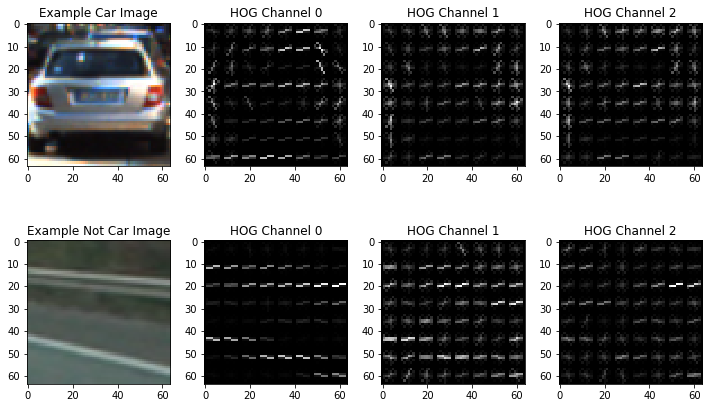

In [27]:
%matplotlib inline
### make HOG example image
# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))
# Read in the car image
car_example = mpimg.imread(cars[ind])

# Generate a random index to look at a notcar image
ind = np.random.randint(0, len(notcars))
# Read in the notcar image
notcar_example = mpimg.imread(notcars[ind])

cvt_car = cv2.cvtColor(car_example, cv2.COLOR_RGB2YCrCb)
cvt_notcar = cv2.cvtColor(notcar_example, cv2.COLOR_RGB2YCrCb)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2

fig = plt.figure(figsize = (10,7))
plt.subplot(241)
plt.imshow(car_example, cmap = 'gray')
plt.title('Example Car Image')
plt.subplot(245)
plt.imshow(notcar_example, cmap = 'gray')
plt.title('Example Not Car Image')
# Call our function with vis=True to see an image output
for ch in range(0, 3):
    
    features, hog_image_car = get_hog_features(cvt_car[:,:,ch], orient, 
                            pix_per_cell, cell_per_block, 
                            vis=True, feature_vec=False)
    features, hog_image_notcar = get_hog_features(cvt_notcar[:,:,ch], orient, 
                            pix_per_cell, cell_per_block, 
                            vis=True, feature_vec=False)
    
    plt.subplot(2,4,2+ch)
    plt.imshow(hog_image_car, cmap='gray')
    plt.title('HOG Channel ' + str(ch))
    
    plt.subplot(2,4,6+ch)
    plt.imshow(hog_image_notcar, cmap='gray')
    plt.title('HOG Channel ' + str(ch))
    plt.tight_layout()
    
plt.savefig("examples/HOG_example.png")

## Linear SVM classifier

In [32]:

# Reduce the sample size because HOG features are slow to compute [test ver.]
#sample_size = 500
#sample_cars = cars[0:sample_size]
#sample_notcars = notcars[0:sample_size]

### TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()

t=time.time()
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

/Users/yujin/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


173.39 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
22.44 Seconds to train SVC...
Test Accuracy of SVC =  0.9907
My SVC predicts:  [ 0.  0.  1.  1.  1.  1.  1.  1.  0.  0.]
For these 10 labels:  [ 0.  0.  1.  1.  1.  1.  1.  1.  0.  0.]
0.04383 Seconds to predict 10 labels with SVC


## Sliding Window Implementation

In [44]:

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, vis = False):
    
    bbox_list = []
    draw_img = np.copy(img)
    img = img.astype(np.float32)#/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)) 
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,1),6) 
                # Assuming each "box" takes the form ((x1, y1), (x2, y2))
                bbox_list.append([[xbox_left, ytop_draw+ystart], [xbox_left+win_draw,ytop_draw+win_draw+ystart]])
                
    if(vis == True):
        return draw_img
    else:
        return bbox_list

/Users/yujin/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


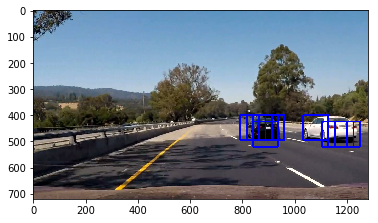

In [45]:
ystart = 400
ystop = 656
scale = 1.5

ind = np.random.randint(0, len(imagedir_lists))
image = mpimg.imread(imagedir_lists[ind])

out_img = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, vis = True)

plt.imshow(out_img)

In [64]:

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,1), 6)
    # Return the image
    return img




/Users/yujin/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


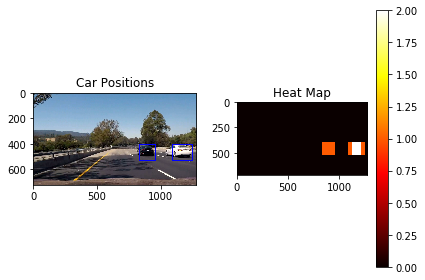

In [71]:
%matplotlib qt
box_list = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

heat = np.zeros_like(image[:,:,0]).astype(np.float)
# Add heat to each box in box list
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat, 0)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
#plt.colorbar()
plt.title('Heat Map')
fig.tight_layout()

/Users/yujin/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


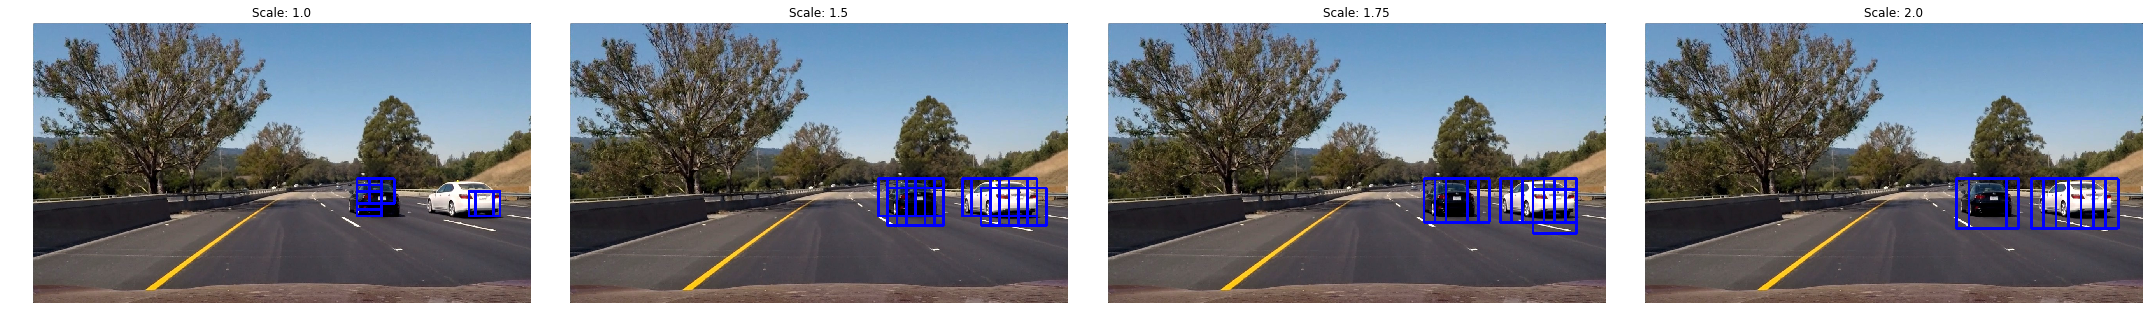

In [124]:
bbox_list = []
scale_list = [1.0, 1.5, 1.75, 2.0]
i = 0
fig = plt.figure(figsize = (30,5))
for scale in scale_list:
    out_img = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, vis = True)
    plt.subplot(1,4,i+1)
    plt.imshow(out_img)
    plt.axis('off')
    plt.title('Scale: ' + str(scale))
    fig.tight_layout()
    
    i += 1
plt.savefig("examples/sliding_window.png")

/Users/yujin/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


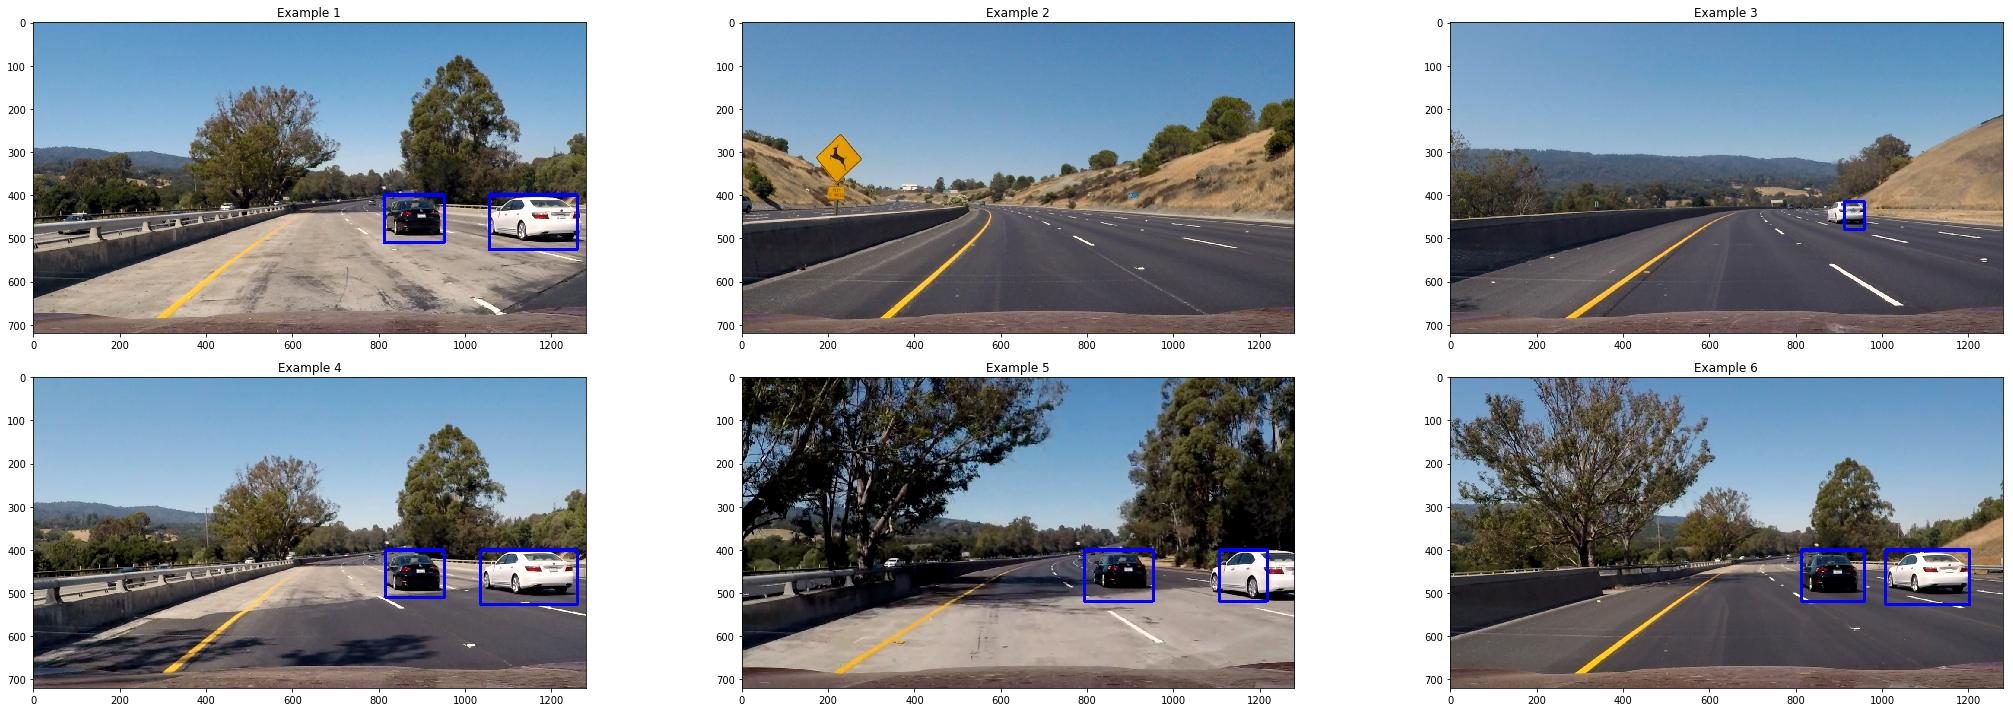

In [123]:
%matplotlib inline

scale_list = [1, 1.5, 1.75, 2.0]
folder_testimg = glob.glob('test_images/*.jpg')
folder_testimg = (sorted(folder_testimg))
i=1
fig = plt.figure(figsize = (30, 10))
imglist =[]
for file in folder_testimg:
    image = mpimg.imread(file)
    image = image/255.0
    bbox_list = []
    for scale in scale_list:
        bboxes = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        for bbox in bboxes:
            bbox_list.append(bbox)

    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,bbox_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 2)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    imglist.append(draw_img)
    
    plt.subplot(2, 3, i)
    plt.imshow(draw_img)
    plt.title('Example '+ str(i))
    i += 1
fig.tight_layout()
plt.savefig("examples/output_bboxes.png")

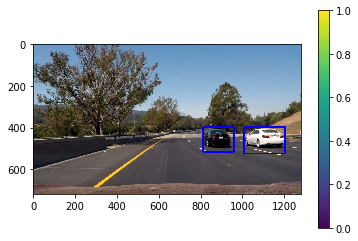

## Test Vedio Result

['video_image/frame0000.png',
 'video_image/frame0001.png',
 'video_image/frame0002.png',
 'video_image/frame0003.png',
 'video_image/frame0004.png',
 'video_image/frame0005.png',
 'video_image/frame0006.png',
 'video_image/frame0007.png',
 'video_image/frame0008.png',
 'video_image/frame0009.png',
 'video_image/frame0010.png',
 'video_image/frame0011.png',
 'video_image/frame0012.png',
 'video_image/frame0013.png',
 'video_image/frame0014.png',
 'video_image/frame0015.png',
 'video_image/frame0016.png',
 'video_image/frame0017.png',
 'video_image/frame0018.png',
 'video_image/frame0019.png',
 'video_image/frame0020.png',
 'video_image/frame0021.png',
 'video_image/frame0022.png',
 'video_image/frame0023.png',
 'video_image/frame0024.png',
 'video_image/frame0025.png',
 'video_image/frame0026.png',
 'video_image/frame0027.png',
 'video_image/frame0028.png',
 'video_image/frame0029.png',
 'video_image/frame0030.png',
 'video_image/frame0031.png',
 'video_image/frame0032.png',
 'video_im

In [128]:
i = 0
dirname = 'result_test_image'
if not os.path.exists(dirname):
    os.makedirs(dirname)
    
    
for file in image_lists:
    image = mpimg.imread(file)
    
    bbox_list = []
    for scale in scale_list:
        bboxes = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        for bbox in bboxes:
            bbox_list.append(bbox)

    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,bbox_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 2)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    draw_img = draw_img*255
    result_bgr = cv2.cvtColor(draw_img, cv2.COLOR_RGB2BGR)
    
    filename = 'result' +str(i).zfill(4) +'.png'
    cv2.imwrite(os.path.join(dirname, filename), result_bgr)
    print(filename)
    i += 1



/Users/yujin/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


result0000.png
result0001.png
result0002.png
result0003.png
result0004.png
result0005.png
result0006.png
result0007.png
result0008.png
result0009.png
result0010.png
result0011.png
result0012.png
result0013.png
result0014.png
result0015.png
result0016.png
result0017.png
result0018.png
result0019.png
result0020.png
result0021.png
result0022.png
result0023.png
result0024.png
result0025.png
result0026.png
result0027.png
result0028.png
result0029.png
result0030.png
result0031.png
result0032.png
result0033.png
result0034.png
result0035.png
result0036.png
result0037.png


In [129]:
import os
from moviepy.editor import ImageSequenceClip

items = os.listdir("result_test_image/")
imagelist = []
for names in items:
    if names.endswith(".png"):
        imagelist.append("result_test_image/" + names)
imagelist = (sorted(imagelist))

clip = ImageSequenceClip(imagelist, fps = 30)
clip.write_videofile("result_test_video.mp4")

[MoviePy] >>>> Building video result_test_video.mp4
[MoviePy] Writing video result_test_video.mp4


100%|██████████| 39/39 [00:02<00:00, 16.72it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result_test_video.mp4 



## Project video result

In [130]:
dirname = 'project_video_image'
if not os.path.exists(dirname):
    os.makedirs(dirname)

vidcap = cv2.VideoCapture('project_video.mp4')
images =[]
ret = True
i = 0
while(ret):
    ret, frame = vidcap.read()
    
    if(ret == False):
        break
    filename = 'frame' +str(i).zfill(4) +'.png'
    cv2.imwrite(os.path.join(dirname, filename), frame)
    i += 1
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
        
vidcap.release()

projImage_lists = glob.glob('project_video_image/*.png')
projImage_lists = (sorted(projImage_lists))



In [132]:
i = 0
dirname = 'output_images'
if not os.path.exists(dirname):
    os.makedirs(dirname)
    
    
for file in projImage_lists:
    image = mpimg.imread(file)
    
    bbox_list = []
    for scale in scale_list:
        bboxes = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        for bbox in bboxes:
            bbox_list.append(bbox)

    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,bbox_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 2)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    draw_img = draw_img*255
    result_bgr = cv2.cvtColor(draw_img, cv2.COLOR_RGB2BGR)
    
    filename = 'result' +str(i).zfill(4) +'.png'
    cv2.imwrite(os.path.join(dirname, filename), result_bgr)
    
    i += 1




In [134]:
items = os.listdir("output_images/")
imagelist = []
for names in items:
    if names.endswith(".png"):
        imagelist.append("output_images/" + names)
imagelist = (sorted(imagelist))

clip = ImageSequenceClip(imagelist, fps = 30)
clip.write_videofile("result_project_video.mp4")

[MoviePy] >>>> Building video result_project_video.mp4
[MoviePy] Writing video result_project_video.mp4


100%|██████████| 1261/1261 [01:41<00:00, 12.43it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result_project_video.mp4 

